In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torchvision.models as models

# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def train(model, trainloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

def evaluate(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")

# Train the model
train(model, trainloader, criterion, optimizer, num_epochs=10)

# Evaluate the model
evaluate(model, testloader)

# Save the model
torch.save(model.state_dict(), "cifar_resnet18_pretrained.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


Epoch [1/10], Loss: 1.0465
Epoch [2/10], Loss: 0.7142
Epoch [3/10], Loss: 0.6232
Epoch [4/10], Loss: 0.5678
Epoch [5/10], Loss: 0.5308
Epoch [6/10], Loss: 0.4919
Epoch [7/10], Loss: 0.4691
Epoch [8/10], Loss: 0.4529
Epoch [9/10], Loss: 0.4310
Epoch [10/10], Loss: 0.4116
Accuracy: 81.06%


In [ ]:
# Create patch (random initialization)
def create_patch(patch_size=(3, 3)):
    patch = torch.randn(3, *patch_size, requires_grad=True, device=device)  # 3채널 (RGB)
    return patch

In [ ]:
def place_patch(img, patch):
    batch_size, _, h, w = img.size()
    ph, pw = patch.size(1), patch.size(2)
    for i in range(batch_size):
        x_offset = torch.randint(0, h - ph + 1, (1,)).item()
        y_offset = torch.randint(0, w - pw + 1, (1,)).item()
        img[i, :, x_offset:x_offset+ph, y_offset:y_offset+pw] = patch
    return img

In [ ]:
def patch_training_step(model, patch, target_class=None, dataloader=None, optimizer=None, criterion=None):
    model.train()
    total_loss = 0
    for images, _ in dataloader:
        images = images.to(device)
        optimizer.zero_grad()
        patched_images = place_patch(images, patch)  # Apply patch to images
        outputs = model(patched_images)
        if target_class is not None:
            labels = torch.full((images.size(0),), target_class, dtype=torch.long, device=device)
        else:
            labels = torch.randint(0, 10, (images.size(0),), device=device)  # Random class for untargeted attack
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def train_adversarial_patch(model, patch, target_class=None, num_epochs=10):
    patch_optimizer = optim.Adam([patch], lr=0.01)  # Use Adam optimizer for learning rate adjustment
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        loss = patch_training_step(model, patch, target_class, trainloader, patch_optimizer, criterion)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

In [ ]:
def evaluate_patch(model, patch, dataloader, target_class=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images, patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)
            if target_class is not None:
                correct += (predicted == target_class).sum().item()
            else:
                correct += (predicted != labels).sum().item()  # Evaluate untargeted attack
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Attack Success Rate: {accuracy:.2f}%")

In [ ]:
# Create and train adversarial patch
patch_size = (5, 5)
patch = create_patch(patch_size)
train_adversarial_patch(model, patch, target_class=None, num_epochs=20)

# Save the patch
torch.save(patch, 'adversarial_patch.pth')

# Evaluate the patch
evaluate_patch(model, patch, testloader, target_class=None)

Epoch 1/20, Loss: 6.9488
Epoch 2/20, Loss: 6.7887
Epoch 3/20, Loss: 6.7133
Epoch 4/20, Loss: 6.5657
Epoch 5/20, Loss: 6.5081
Epoch 6/20, Loss: 6.4637
Epoch 7/20, Loss: 6.4560
Epoch 8/20, Loss: 6.3807
Epoch 9/20, Loss: 6.3527
Epoch 10/20, Loss: 6.4140
Epoch 11/20, Loss: 6.3369
Epoch 12/20, Loss: 6.3562
Epoch 13/20, Loss: 6.3543
Epoch 14/20, Loss: 6.3144
Epoch 15/20, Loss: 6.2943
Epoch 16/20, Loss: 6.3416
Epoch 17/20, Loss: 6.2855
Epoch 18/20, Loss: 6.3120
Epoch 19/20, Loss: 6.2811
Epoch 20/20, Loss: 6.3061
Attack Success Rate: 59.34%


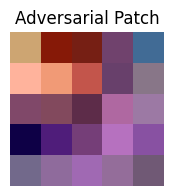

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Visualize the patch
def visualize_patch(patch):
    patch = patch.detach().cpu().numpy()
    patch = np.clip((patch - patch.min()) / (patch.max() - patch.min()), 0, 1)

    plt.figure(figsize=(2, 2))
    plt.imshow(np.transpose(patch, (1, 2, 0)))  # [C, H, W] -> [H, W, C]
    plt.title("Adversarial Patch")
    plt.axis('off')
    plt.show()

visualize_patch(patch)

In [ ]:
def visualize_misclassified_patched_images(model, patch, dataloader, classes, num_examples=5):
    model.eval()
    examples_shown = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        patched_images = place_patch(images.clone(), patch)
        with torch.no_grad():
            original_preds = model(images).argmax(dim=1)
            patched_preds = model(patched_images).argmax(dim=1)
        for i in range(images.size(0)):
            # Display only if the original prediction is correct and the patched prediction is incorrect
            if original_preds[i] == labels[i] and patched_preds[i] != labels[i]:
                # Normalize back to [0, 1] range for visualization
                original_image = (images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5
                patched_image = (patched_images[i].cpu().detach().numpy().transpose(1, 2, 0) * 0.5) + 0.5

                # Plot images with a fixed size to match CIFAR-10
                fig, axes = plt.subplots(1, 2, figsize=(4, 4))
                axes[0].imshow(np.clip(original_image, 0, 1))
                axes[0].set_title(f"Original Image\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[original_preds[i].item()]}")
                axes[0].axis('off')

                axes[1].imshow(np.clip(patched_image, 0, 1))
                axes[1].set_title(f"Image with Adversarial Patch\nTrue Label: {classes[labels[i].item()]}\nPredicted: {classes[patched_preds[i].item()]}")
                axes[1].axis('off')

                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return

<ipython-input-15-88212973b229>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch = torch.load('adversarial_patch.pth')


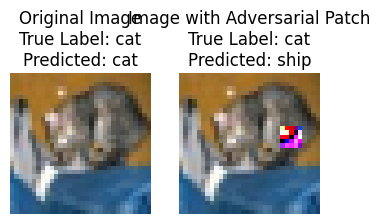

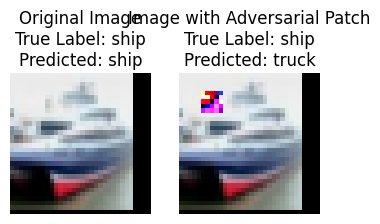

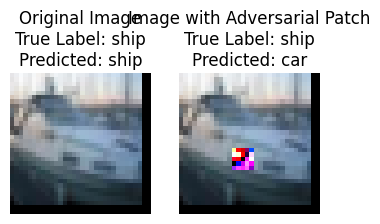

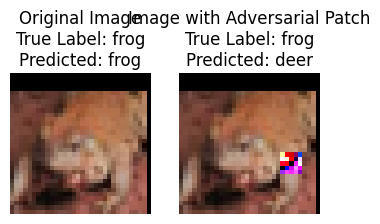

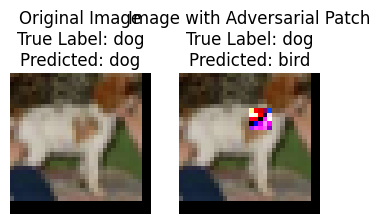

In [ ]:
# Load saved patch
patch = torch.load('adversarial_patch.pth')
patch.requires_grad = True

# CIFAR-10 class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize misclassified examples with the adversarial patch
visualize_misclassified_patched_images(model, patch, testloader, classes, num_examples=5)

In [ ]:
def evaluate_patch_success_rate(model, patch, dataloader):
    model.eval()
    successful_attacks = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            patched_images = place_patch(images.clone(), patch)
            outputs = model(patched_images)
            _, predicted = outputs.max(1)

            # Count successful untargeted attacks (where prediction differs from true label)
            successful_attacks += (predicted != labels).sum().item()
            total_samples += labels.size(0)

    success_rate = 100 * successful_attacks / total_samples
    print(f"Untargeted Attack Success Rate: {success_rate:.2f}%")
    return success_rate

# Evaluate untargeted attack success rate on CIFAR-10 dataset
evaluate_patch_success_rate(model, patch, testloader)

Untargeted Attack Success Rate: 59.74%


59.74